# Testing Algorithms for Paper

## Name: Victor Agaba

## Date: 2024-04-11

***

In [28]:
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as sm
from package import optimizer as opt
from package import plots
import numpy as np
from obspy.taup import TauPyModel

In [ ]:
# from obspy.clients.fdsn import Client
# from obspy import UTCDateTime

# import os

# # I want instrument response from MBAR station
# # Make sure Ao is correct

# # Define paths and parameters
# path = os.getcwd()
# dst = os.path.join(path, 'Stationxml/')
# os.makedirs(dst, exist_ok=True)

# client = Client("IRIS")
# netsclts = {"II": "IRIS"}
# starttime = UTCDateTime(2001, 1, 1, 0, 0, 0)
# endtime = UTCDateTime(2020, 12, 12, 23, 59, 59)

# # Loop through networks and retrieve metadata
# for net in list(netsclts.keys()):
#     client = Client(netsclts[net])
#     inventory = client.get_stations(
#         starttime=starttime,
#         endtime=endtime,
#         network=net,
#         sta="MBAR",
#         loc="00",
#         channel="*",
#         level="response"
#     )
#     # inventory.write(dst + f"metadata.{net}.xml", format="STATIONXML")
#     # print(f"Metadata for {net} written to {dst}")

#     # Plot instrument response for displacement
#     for network in inventory:
#         # print('yes1')
#         # print(network)
#         # print(type(network))
#         for station in network:
#             # print('yes2')
#             # print(station)
#             # print(type(station))
#             for channel in station:
#                 # print('yes3')
#                 # print(type(channel))
#                 # print(channel.code)
#                 # print(channel.calibration_units)
#                 # print every attribute of channel
#                 for attr in dir(channel):
#                     print(attr)
#                 # break
#                 if channel in ["BH1", "BH2", "BHZ"]:
#                     print('yes')
#                     response = channel.response
#                     if response:
#                         print(f"Plotting instrument response for {channel.code}")
#                         response.plot(0.001, output="DISP")  # Frequency 0.001 Hz



__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
__weakref__
_alternate_code
_azimuth
_clock_drift_in_seconds_per_sample
_code
_depth
_dip
_elevation
_equipments
_historical_code
_identifiers
_latitude
_location_code
_longitude
_repr_pretty_
_sample_rate
_source_id
_water_level
alternate_code
azimuth
calibration_units
calibration_units_description
clock_drift_in_seconds_per_sample
code
comments
copy
data_availability
data_logger
depth
description
dip
elevation
end_date
equipment
equipments
external_references
historical_code
identifiers
is_active
latitude
location_code
longitude
plot
pre_amplifier
response
restricted_status
sample_rate
sample_rate_ratio_number_samples
sample_rate_ratio_number_seconds
sensor
source_id
start_date
storage_format
types
water_level
__class__
_

***
#### Synthetic Parameters
***

Seed: 8788
Original params:  [270.14922965  55.43580302 135.73765929]


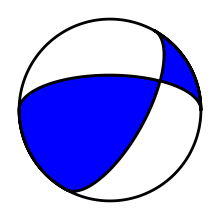

[45.74277419944782, 49.94361025435123]


In [58]:
seed = np.random.randint(0, 20250)
np.random.seed(seed)
print(f'Seed: {seed}')

# np.random.seed(2024)
# np.random.seed(1513)
# np.random.seed(555)

# # BUG plot_iterates_2D (off by 1)
# np.random.seed(560)

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)

# get truen params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
print(takeoff_angles)
velocities = np.array([5.8000, 3.4600])

# NOTE: Be aware of more than one P/S arrival
# Plot beachball set: grid + ordered overlay
# Example events (Paula) --- Mars later
# Laplacians (finite differences)
# Moment tensor
# Alt cost function --- later

***
#### Hybrid Inversion
***

In [59]:
importlib.reload(fn)
importlib.reload(sm)
importlib.reload(opt)
importlib.reload(plots)

# initialize model
inv_model = sm.SeismicModel(np.deg2rad(azimuth), takeoff_angles, velocities)
best_fit = inv_model(np.deg2rad(true_params), set_Ao=True)

# tune hyperparameters
config = opt.get_config()

# initialize random hybrid search: many runs
num_runs = 50
starts = fn.random_params(num_runs)

# # initialize systematic hybrid search: debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_runs = len(starts)

# multi-start optimization
inv_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_runs}')
    opt.minimize(inv_model, config, start)
    
print(f'Convergence rate: {inv_model.get_convergence_rate():.0f}%')

Run 0 of 50
Run 10 of 50
Run 20 of 50
Run 30 of 50
Run 40 of 50
Convergence rate: 98%


Axis: T
Optimal parameters: [ 5.69457134 40.22616662 16.61001537]
Search error: 0.9077204084391738 degrees


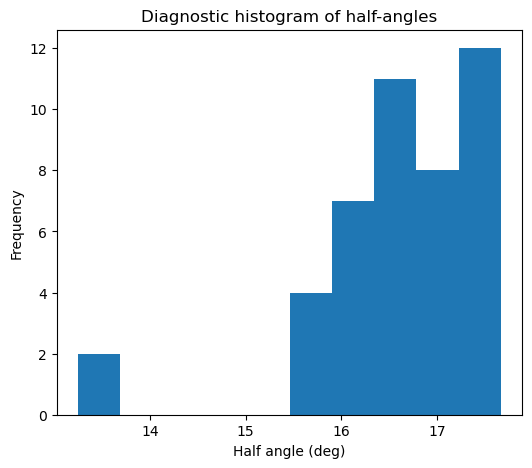

In [60]:
params, error, position = inv_model.get_optimal_parameterization()
name = 'T' if position == 0 else 'P'

print(f'Axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

plots.half_angles(inv_model, bins=10)

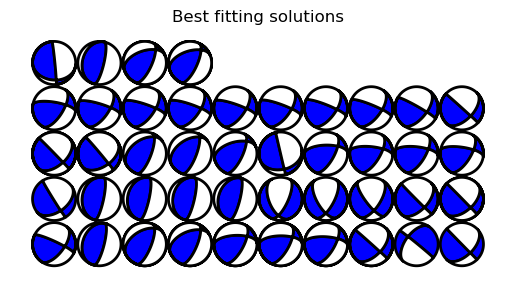

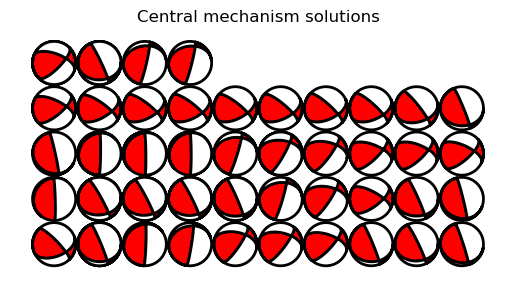

In [61]:
# beachball plots
plots.beachballs(inv_model, central=False, order_by='strike')
plots.beachballs(inv_model, central=True, order_by='strike')

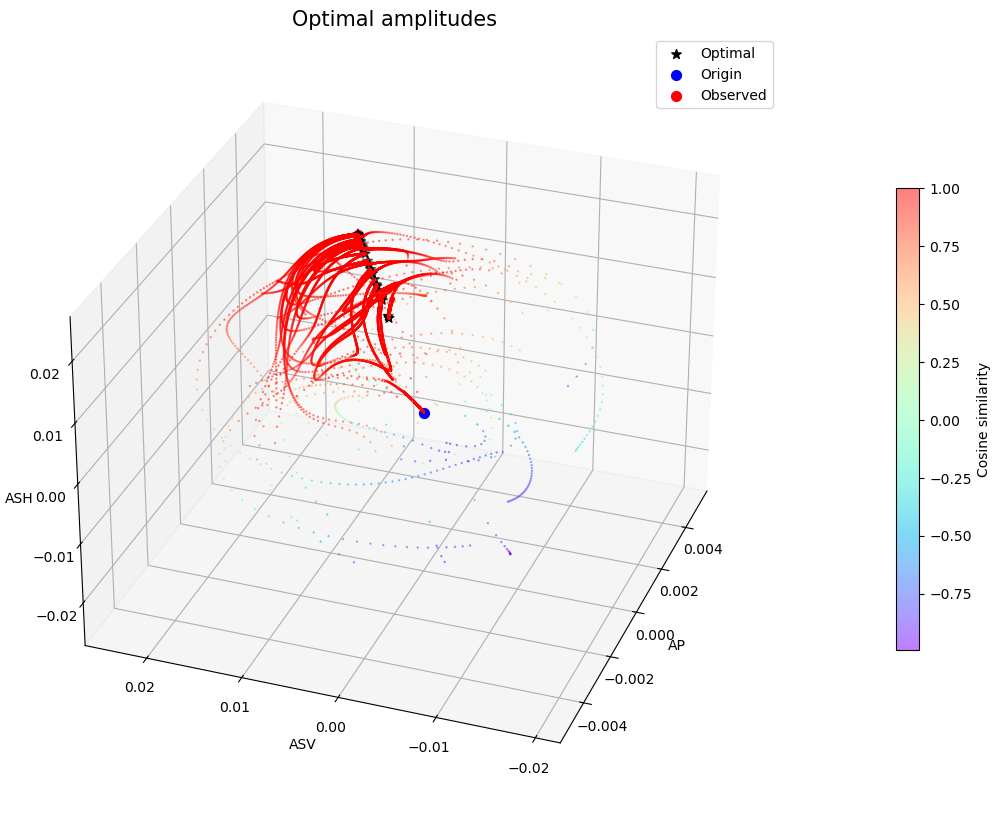

In [62]:
# amplitude plot
# TODO: include marker at origin
plots.amplitudes(inv_model, azim=200, elev=30, s=50, alpha=0.5, iterates=True)

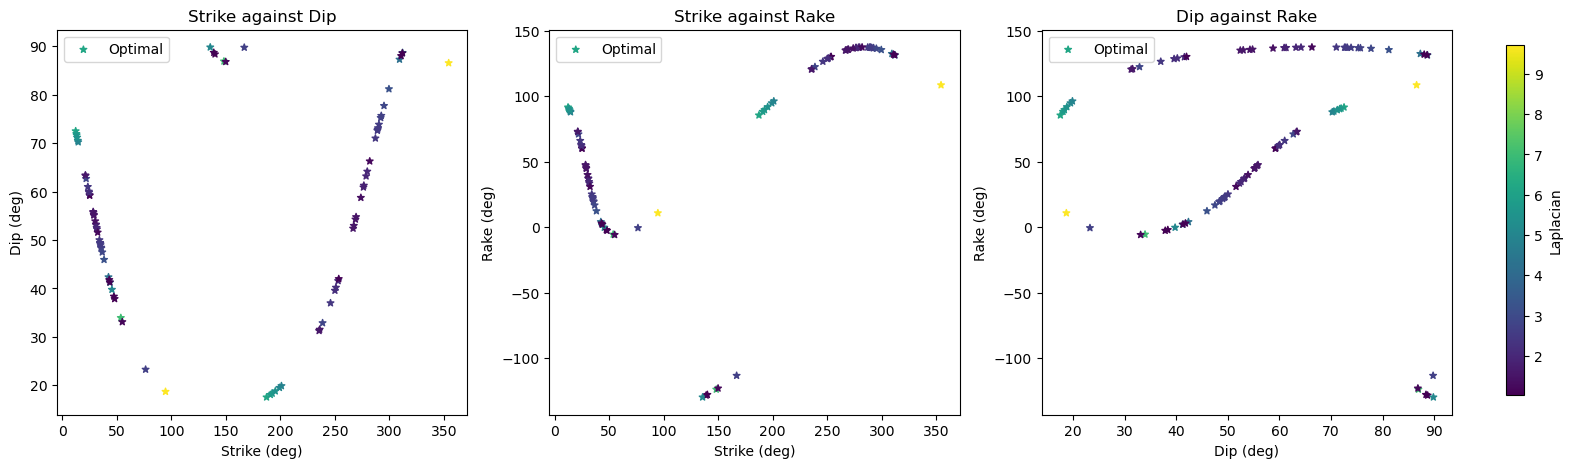

In [63]:
# iterate plot - sdr space
plots.iterates_2D(inv_model, s=25, optimal=True, index=2, cmap='viridis')
# plots.iterates_2D(s=1, optimal=False, index=0)
# plots.iterates_2D(s=1, optimal=False, index=1)

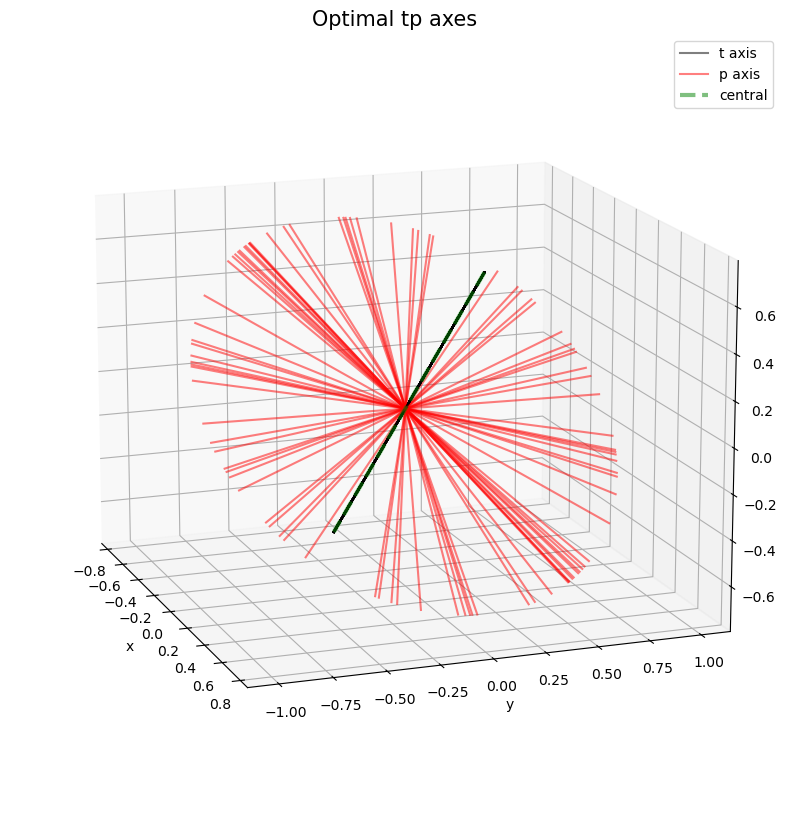

In [64]:
# optimal plot - tp space, collapse to central
plots.tp_axes(inv_model, azim=-20, elev=15, half=False, central=True)

***
#### Uncertainty Propagation
***

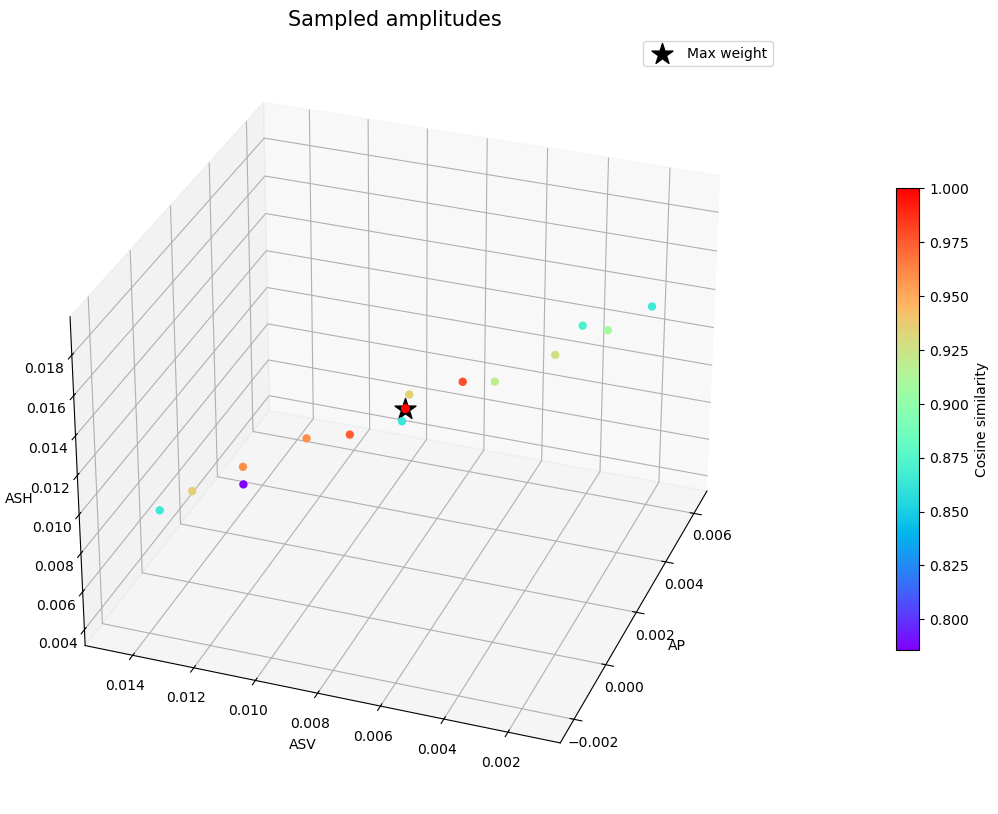

In [65]:
# dd, num_samples = 15, 25
dd, num_samples = 30, 15  # debugging
inv_model.init_uncertainty()
inv_model.sample_amplitudes(dd, num_samples)
plots.sampled_amplitudes(inv_model, cmap='rainbow', s=25, azimuth=200, elevation=30)

In [66]:
num_runs, print_every = 30, 0
inv_model.monte_carlo(dd, num_samples, num_runs, print_every)

Sample 0 of 18
Sample 1 of 18
Sample 2 of 18
Sample 3 of 18
Sample 4 of 18
Sample 5 of 18
Sample 6 of 18
Sample 7 of 18
Sample 8 of 18
Sample 9 of 18
Sample 10 of 18
Sample 11 of 18
Sample 12 of 18
Sample 13 of 18
Sample 14 of 18
Sample 15 of 18
Sample 16 of 18
Sample 17 of 18


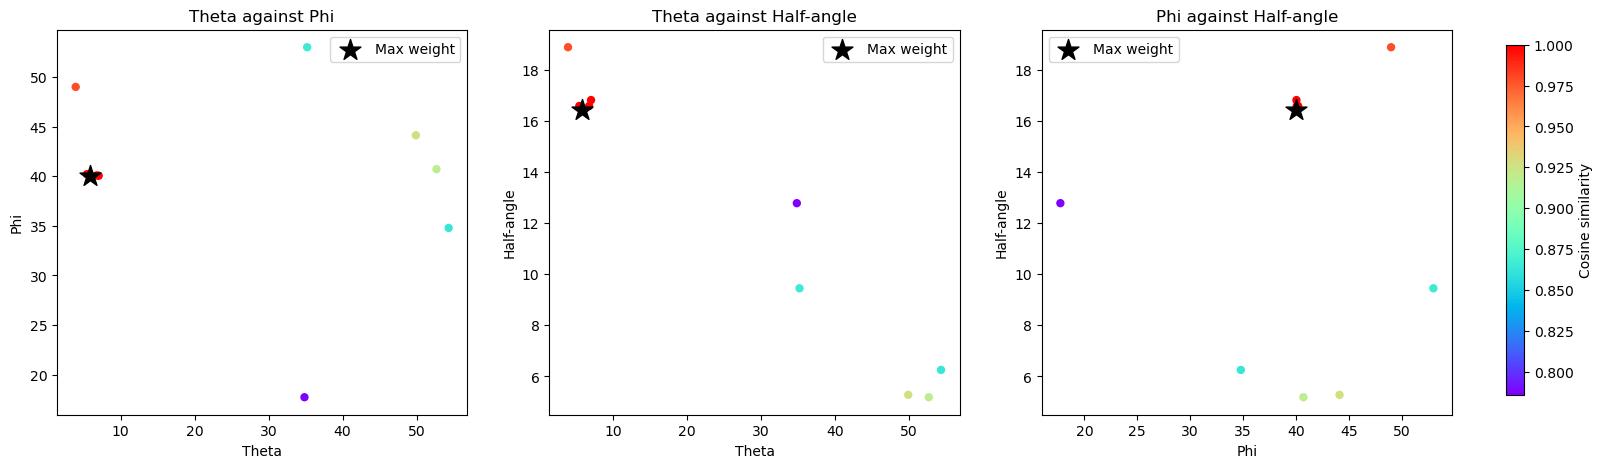

In [67]:
# monte carlo plot - cone space
error_threshold = 5
inv_model.post_filter(threshold=error_threshold)
plots.uncertainty_2D(inv_model, s=25, scale=0)
# plots.uncertainty_3D(elev=30, azim=45, s=25)

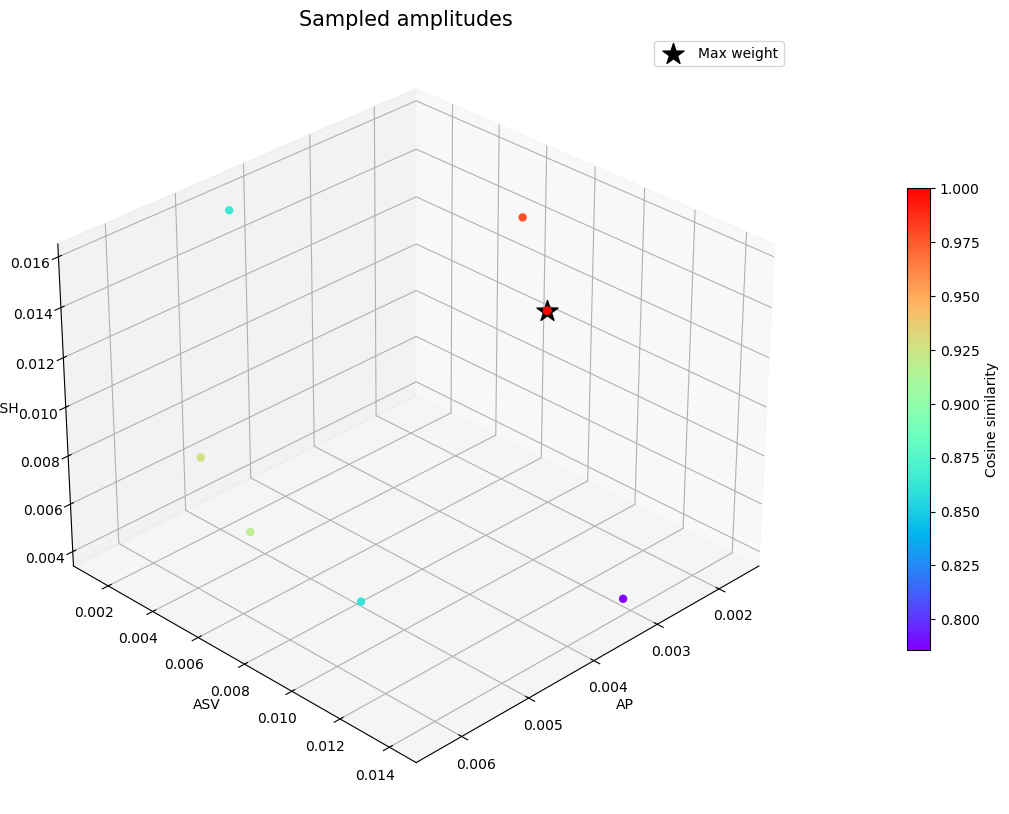

In [68]:
plots.sampled_amplitudes(inv_model, cmap='rainbow', s=25)

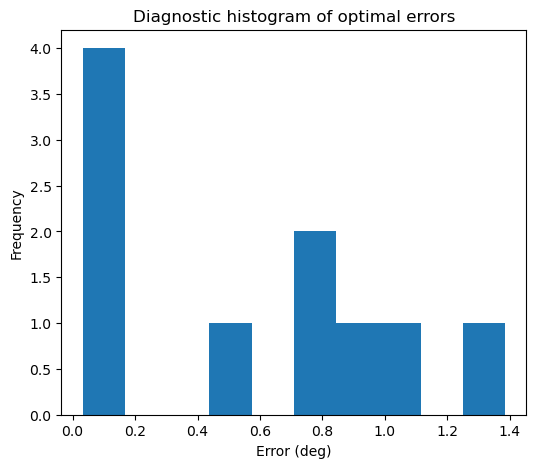

In [69]:
# diagnostic plot of monte carlo errors
plots.optimal_errors(inv_model, bins=10)